# Анализ успешности игр в интернет-магазине «Стримчик»


Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры.

Цель исследования - выявить определяющие успешность игры закономерности. 

Зачем нужно исследование? Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию:
- E - для всех возрастов
- ЕС - для детей от 3 лет
- Е10 - для детей старше 10 лет
- Т - для подростков от 13 лет
- М - для взрослых от 17 лет

## Знакомство с данными

In [2]:
#Импорт библиотек, используемых в проекте

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st

In [3]:
#Загрузка файла

data = pd.read_csv('/datasets/games.csv')
display(data.head(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание колонок:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB

In [4]:
#Общая информация: Тип данных по колонкам, пропущенные значения

data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

В датасете есть несколько моментов, которые требуют дополнительной предобработки: некоторые типы данных не соответствуют ожидаемым, например, год указан дробным числом, хотя является явным целочисленным. Также есть несколько пропусков, при этом уже сейчас видно, что 2 пропуска в названиях игр и жанров явно являются неважными. 

В целом, датасет заполнен достаточно полно, так как цель исследования - выяснить потенциально прибыльные продукты, а значит наиболее важными параметрами являются суммы по продажам, в то время как оценки и рейтинг будут уже второстепенными параметрами. Условно, являясь поклонником серии игр геймер будет брать все новые версии этой игры и, чаще всего, дополнения к ней, даже если в итоге игра оставит негативные впечатления - та самая частая картина отзывов на тему "Раньше было лучше".

## Предобработка данных

Для удобства работы с данными приведём все столбцы в строчной регистр и проверим наличие полных дубликатов.

In [5]:
data.columns = data.columns.str.lower()

data.duplicated().sum()

0

Задублированных строк в датасете нет.

### Анализ пропущенных значений

In [6]:
(data.isna().sum()/len(data)*100).round(2) #Процент пропущенных значений от общего числа строк

name                0.01
platform            0.00
year_of_release     1.61
genre               0.01
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
critic_score       51.32
user_score         40.09
rating             40.48
dtype: float64

Датасет состоит из **16713** строк, пропущенные значения есть в 6 столбцах из 11.

Пропуски будут обрабатываться следующим образом:
- name, genre, year_of_release - удаление
 - Пропущенных значений менее 2%, удаление строк не исказит общую картину
- critic_score, user_score, rating - заглушка nan
 - Пропущенные значения будут заменены на nan, т.к. рейтинг - это оценка многокомпонентная. Для игр в одном жанре, одного года выпуска, одной студии оценки всё равно могут быть разными, формируясь из пользовательского опыта, сюжетной линии, игровой механики и пр. Пропусков много, но их замена медианами или средними значениями будет искажением реальных данных.
 - Рейтинг от ESRB уступает системе PEGI, действующей на территории большинства европейских стран. То есть одна и та же игра может получить разный рейтинг в зависимости от страны из-за разного деления по возрастам. Так, например, **Е10+** в ESRB означает игры для детей от 10 лет, в то время как PEGI имеет шкалу **PEGI 7** и **PEGI 12**, а соответственно игры категории **E10+** могут быть пересмотрены как на младшую аудиторию, так и на старшую. Поэтому ни максимальное значение рейтинга, ни часто встречаемое значение в рамках одного жанра не будет достоверным.
 
Отдельно стоит обратить внимание на значения tbd в датасете. Пользовательский рейтинг tbd (To Be Determined) означает, что рейтинг подлежит уточнению и по сути является тем же пустым значением nan. 

In [7]:
#Удаление строк с неизвестным названием игры

data.dropna(subset=['name'], inplace=True)
data = data.reset_index(drop=True)


#Проверка, что пропущенных значений в названии игр нет

print(data['name'].isna().sum())

0


In [8]:
#Удаление строк с неизвестным жанром игры

data.dropna(subset=['genre'], inplace=True)
data = data.reset_index(drop=True)


#Проверка, что пропущенных значений в жанре игр нет

print(data['genre'].isna().sum())

0


In [9]:
#Удаление строк с неизвестным годом релиза

data.dropna(subset=['year_of_release'], inplace=True)
data = data.reset_index(drop=True)


#Проверка, что пропущенных значений в дате релиза нет

print(data['year_of_release'].isna().sum())

0


In [10]:
#Заглушка nan для рейтинга

data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data.loc[:,'critic_score'] = data.loc[:,'critic_score'].fillna(float('nan'))
data.loc[:,'rating'] = data.loc[:,'rating'].fillna(float('nan'))

### Типы данных

In [11]:
data.dtypes #Проверка типов

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Некоторые типы данных датасета не сооветствуют ожидаемым и требуют переопределения.

| Колонка | Тип в датасете | Ожидаемый тип | Обоснование замены |
|---|---|---|---|
| name | object | object | - |
| platform | object | object | - |
| year_of_release | float64 | int | Так как в колонке нет полноценного формата даты, а есть только год, то достаточно привести значения к целому числу |
| genre | object | str | В названии жанров нет цифр, это просто слово |
| na_sales | float64 | float64 | - |
| eu_sales | float64 | float64 | - |
| jp_sales | float64 | float64 | - |
| other_sales | float64 | float64 | - |
| critic_score | float64 | float64 | - |
| user_score | object | float64 | Пользовательский рейтинг также, как и рейтинг критиков может быть дробным числом |
| rating | object | str | Рейтинг от ESRB - текст |

In [12]:
#Замена типов

data = data.astype({'year_of_release': 'int32', 'genre': 'string', 'user_score': 'float64', 'rating': 'string'}, errors="ignore")

data.dtypes

name                object
platform            object
year_of_release      int32
genre               string
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              string
dtype: object

## Исследовательский анализ данных (общие данные)

Добавим в датасет суммарные продажи по всем регионам.

In [13]:
data['sales_total'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].agg('sum', axis=1)

data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,<NA>,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,<NA>,31.38


### Год релиза

Посмотрим сколько игр выпускалось в разные периоды.

[Text(0.5, 0, 'Год выпуска'), Text(0, 0.5, 'Количество')]

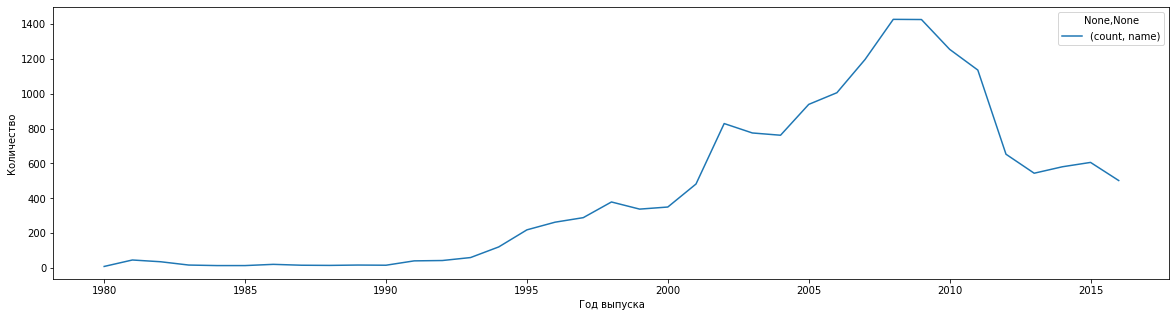

In [14]:
data.pivot_table(index='year_of_release', values='name', aggfunc=['count']).plot(figsize=(20,5)).set(xlabel='Год выпуска', ylabel='Количество')

На графике видно несколько ступеней, разберём подробнее.

Наибольшее количество игр было выпущено в 2008, наименьшее - в 1980.

In [15]:
data.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

#### Рост в 1993-94

Отчётливо виден резкий скачок, произошедший в 1993-94 годах. Резкий рост выпущенных игр напрямую связан с первой приставкой PS, вышедшей на рынок Японии 3 декабря 1994 года.

Если посмотреть первое появление платформы PS в датасете, то самый ранний год релиза игр начинается именно с 1994.

In [16]:
display(data.query('platform == "PS"').sort_values(by='year_of_release').head(1))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
1551,Battle Arena Toshinden,PS,1994,Fighting,0.39,0.26,0.53,0.08,69.0,6.3,T,1.26


PS была не единственной платформой, появившейся на рынке игр. Если до 1994 года игры выпускались только на 10 платформах, то после 2000 их количество выросло вдвое - до 20.

In [17]:
print('Платформы до 1994 года', data.loc[data['year_of_release'] < 1994]['platform'].unique(), '\n')

print('Платформы после 2000 года', data.loc[data['year_of_release'] > 2000]['platform'].unique())

Платформы до 1994 года ['NES' 'GB' 'SNES' '2600' 'GEN' 'PC' 'SCD' 'NG' 'GG' 'DS'] 

Платформы после 2000 года ['Wii' 'DS' 'X360' 'PS3' 'PS2' 'GBA' 'PS4' '3DS' 'XB' 'PC' 'PSP' 'XOne'
 'WiiU' 'GC' 'PS' 'PSV' 'GB' 'N64' 'DC' 'WS']


Но с ростом новых платформ более старые оказываются уже неспособными поддерживать требования самих игр, а значит и не могут обеспечить новый уровень игрового опыта, что приводит иногда к полной остановке развития и обновления платформ. В частности, видно, что после 2000 года исчезла платформа NES - их закат популярности пришёлся на 1995 год и тогда же американское отделение объявило о полном прекращении продаж, хотя японское отделение и продолжало поддерживать выпущенные консоли, ремонтируя их вплоть до 2007 года. Игры же NES после официального прекращения продаж остались же доступны в новых поколениях платформ - Nintendo 3DS и Wii U.

#### Определение лидеров в 1995

Развитие игровой индустрии начиналось в нескольких точках, что способствовало с одной стороны появлению разных компаний-основателей, которые двигали индустрию, а с другой - к большой конкуренции и перенасыщению рынка. Sega, Nintendo, Atari и многие другие предлагали свои продукты, но в итоге выдержать конкуренцию с быстро растущей популярностью PlayStation от Sony и CD-играми смогли далеко не все. Большинство отсеялось примерно к 1995 году, поэтому для исследовательского анализа данных имеет смысл смотреть данные именно за период после 1994 года.

Все данные до него же попадают как раз в категорию конкурентной борьбы, малого срока жизни платформы и малого, чаще всего, количества выпущенных игр.

На эту тему есть хорошая [статья на Хабре](https://habr.com/ru/company/miip/blog/312884/), где в таблице наглядно видно как определялись лидеры рынка.

#### Рост в 2002

Второй заметный рост по количеству выпущенных игр произошёл в 2002 году. Связано это было с выходом Xbox - главного конкурента платформы PS. Впервые Xbox появился в 2001 году на территории США и Канады, а вот в 2002 произошёл выход на общий рынок.

Если посмотреть как менялись продажи, то рост становится объяснимым:
- В 2001 году Sony удерживает лидерство за счёт производства игр на две платформы: PS и PS2.
- В том же 2001 году Nintendo представляет новую платформу GBA, предлагая геймерам портативность и компактный форм-фактор, что позволило захватить большой сегмент аудитории
- В 2002 PS2 и GBA остались лидерами рейтинга, и в то же время на мировой рынок вышел Xbox. 

Успех Xbox был вызван несколькими факторами, среди которых была продажа консолей ниже себестоимости при высокой производительности на тот момент, то есть по сути Microsoft продавала устройства следующего поколения по цене предыдущего. Хорошая рекламная кампания, архитектура идентичная архитектуре Windows, что позволяло разработчикам легче портировать игры, популярность шутера Halo - всё это также способствовало попаданию Xbox на уровень действующих лидеров.

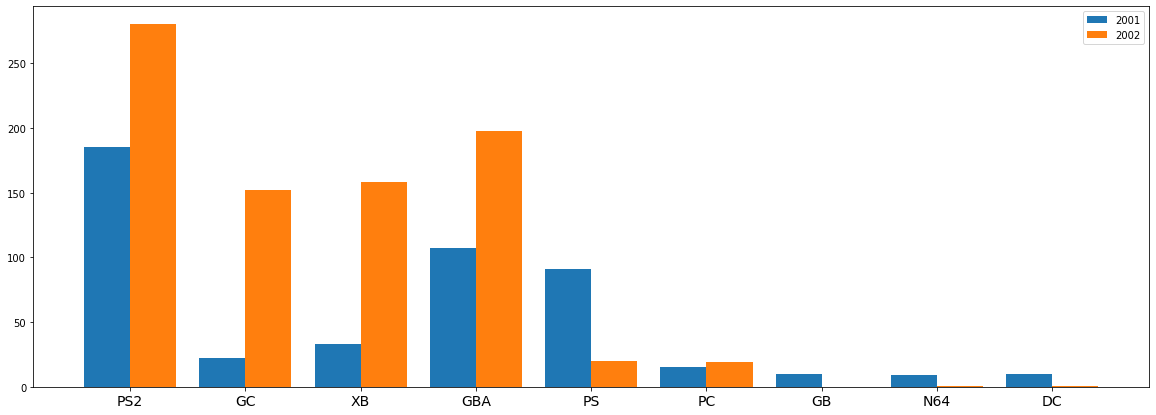

In [18]:
x = data.query('year_of_release == 2001')['platform']
y = data.query('year_of_release == 2002')['platform']

plt.figure(figsize=(20,7))
plt.hist([x, y], label=['2001', '2002'], bins=range(10), align='left')
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

#### Спад в 2012

Разработка игр постепенно стала требовать больше ресурсов и финансовых средств, становясь полноценным бизнесом и переходя в категорию коммерчески выгодного продукта. Начали появляться переиздания вместо новых идей, а также луты и донаты, что вызывало негодования игроков, вынужденных оплачивать не только подписку, но и дополнительные предметы для комфортной игры.

Параллельно с этим продолжало активно развиваться направление мобильных игр: например, App Store в январе 2011 года имело 350 тысяч приложений, а в феврале 2012 - свыше 500 тысяч.

В итоге, можно увидеть как за год упали продажи на всех платформах, кроме Wii U, чей год выхода был как раз в 2012. 

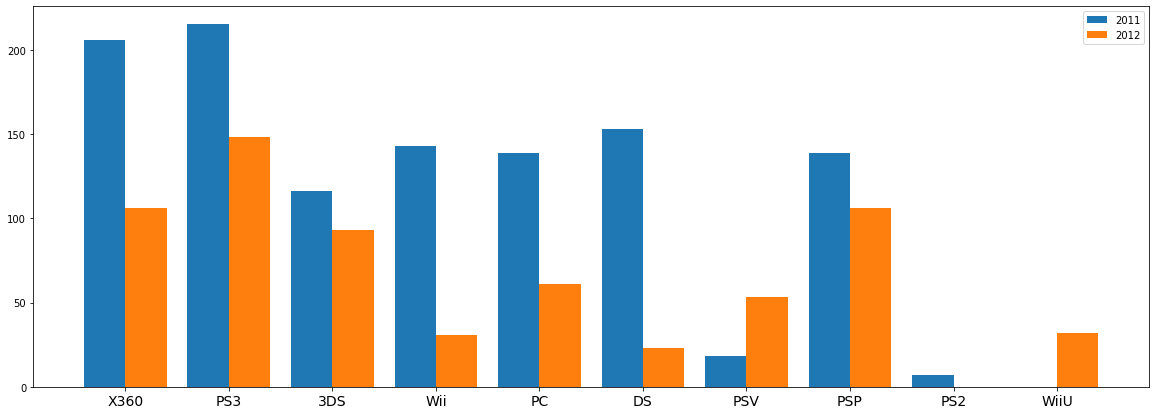

In [19]:
x = data.query('year_of_release == 2011')['platform']
y = data.query('year_of_release == 2012')['platform']

plt.figure(figsize=(20,7))
plt.hist([x, y], label=['2011', '2012'], bins=range(11), align='left')
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

### Платформы

#### Лидеры по продажам

Если посмотреть сколько же всего игр было выпущено для разного типа платформ и заработано денег, то лидер - PS2, а на последнем месте - PCFX с 1 выпущенной игрой.

In [20]:
data.pivot_table(index='platform', values=['sales_total', 'name'], aggfunc={'sales_total':np.sum, 'name':np.count_nonzero}).sort_values(by='sales_total', ascending=False)

,name,sales_total
platform,,
PS2,2127,1233.56
X360,1232,961.24
PS3,1306,931.34
Wii,1286,891.18
DS,2121,802.78
PS,1190,727.58
PS4,392,314.14
GBA,811,312.88
PSP,1193,289.53


Платформами с наибольшим количеством продаж являются первые 6 позиций, а затем сумма продаж падает вдвое.

Если посмотреть график распределения продаж именно по первым шести позициям, то видно, как поколения консолей сменяют друг друга: продажи игр предыдущего поколения идут на спад, в то же время новое поколение подхватывает аудиторию и продажи снова растут вверх.

<AxesSubplot:xlabel='year_of_release'>

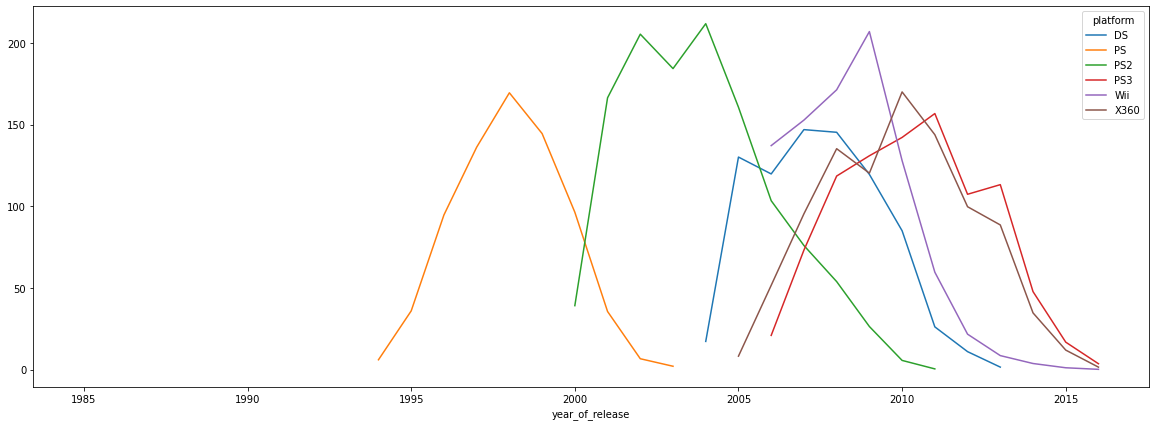

In [21]:
top_platform_sales = data.groupby('platform')['sales_total'].sum().sort_values(ascending=False).head(6)
data.query('platform in @top_platform_sales.index').pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum').plot(figsize=(20,7))

#### Средний срок жизни платформ

Срок жизни всех платформ с учётом первых консолей составляет от 0 до 31 года, однако срок жизни для DS в 28 лет выглядит аномальным.

In [22]:
data.pivot_table(index='platform', values=['year_of_release', 'sales_total'], 
                 aggfunc={'year_of_release':[min, max, np.ptp], 'sales_total': 'sum'}).sort_values(('year_of_release','ptp'), ascending=False)

sales_total year_of_release          
                 sum             max   min ptp
platform                                      
PC            255.76            2016  1985  31
DS            802.78            2013  1985  28
GB            254.43            2001  1988  13
X360          961.24            2016  2005  11
PSP           289.53            2015  2004  11
PS2          1233.56            2011  2000  11
NES           251.05            1994  1983  11
DC             15.95            2008  1998  10
Wii           891.18            2016  2006  10
PS3           931.34            2016  2006  10
2600           86.48            1989  1980   9
SNES          200.04            1999  1990   9
PS            727.58            2003  1994   9
XB            251.57            2008  2000   8
GBA           312.88            2007  2000   7
GC            196.73            2007  2001   6
N64           218.01            2002  1996   6
3DS           257.81            2016  2011   5
PSV            53.81            2016  2011   5
SAT            33.59            1999  1994   5
WiiU           82.19            2016  2012   4
GEN            28.35            1994  1990   4
NG              1.44            1996  1993   3
XOne          159.32            2016  2013   3
PS4           314.14            2016  2013   3
WS              1.42            2001  1999   2
3DO             0.10            1995  1994   1
SCD             1.86            1994  1993   1
TG16            0.16            1995  1995   0
PCFX            0.03            1996  1996   0
GG              0.04            1992  1992   0

Проверим аномальность значения платформы DS - вероятнее всего, в какой-то из игр ошибочно указана дата первого релиза, т.к Nintendo DS - преемник Game Boy и её анонс состоялся в 2004 году.

In [23]:
#Проверка аномальных значений платформы DS

display(data.query('platform == "DS" and year_of_release < 2004'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
15704,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,<NA>,0.02


Действительно, в датасете есть только одна игра для платформы DS, датируемая раньше 2004.

Проверим реальную дату выхода. Strongest Tokyo University Shogi DS анонсирована в Японии под названием 最強の東大将棋 и на сайте [Nintendo](https://www.nintendo.co.jp/ds/software/a4qj/index.html) действительно указана другая дата. Игра была выпущена не в 1985 году, а в 2007, поэтому значение в датасете является ошибочным.

In [24]:
#Замена даты выхода аномального значения

data['year_of_release'] = np.where((data['platform']=="DS") & (data['name']=="Strongest Tokyo University Shogi DS"), '2007', data['year_of_release']).astype('int32')

После обработки аномального значения можно уточнить срок жизни популярных платформ по ранее определённому списку из шести лидеров.

У популярных платформ срок жизни немногим больше, чем в среднем по датасету, и составляет примерно 10 лет. 
Ранее на графике были видны пересечения, но через табличный вид можно уточнить диапазон пересечения точнее. По таблице хорошо видно как менялись поколения Playstation - первая консоль выпущена в 1994 и ушла с рынка в 2003, но уже в 2000 вместо неё на рынок вышла PS2. 

Также на примере Sony можно утверждать, что пересечения продаж при переходе на новое поколение продолжаются примерно 3-4 года.

In [25]:
data.pivot_table(index='platform', values=['year_of_release', 'sales_total'], 
                 aggfunc={'year_of_release':[min, max, np.ptp], 'sales_total': 'sum'}).sort_values(('sales_total','sum'), ascending=False).head(6)

sales_total year_of_release          
                 sum             max   min ptp
platform                                      
PS2          1233.56            2011  2000  11
X360          961.24            2016  2005  11
PS3           931.34            2016  2006  10
Wii           891.18            2016  2006  10
DS            802.78            2013  2004   9
PS            727.58            2003  1994   9

## Исследовательский анализ данных (актуальный период)

### Определение границ актуального периода

Так как целью исследования является прогноз на будущее, то требуется отсечь неактуальные данные. Ранее было определено, что:
- конкурентная борьба закончилась примерно в 1995 году
- существенный спад продаж произошёл в 2012 году
- есть 6 лидеров по продажам, даты выхода платформ находятся в диапазоне 1994 - 2016


Если строить исследование на основе жизненного цикла лидирующих платформ, то получается, что периодом для анализа выступают 22 года. Но учитывая срок жизни платформ, который составляет примерно 10 лет - такой период захватит в том числе и устаревшие поколения консолей.

Уточним период, проверив не только даты релиза на платформах, но и сравнив количество выпущенных игр.

In [26]:
#Таблица по суммам продаж
display(data
 .query('year_of_release > 1994')
 .pivot_table(index='platform', values=['sales_total', 'year_of_release'],
                 aggfunc={'sales_total':np.sum, 'year_of_release': [min, max]})
.sort_values(('sales_total','sum'), ascending=False).head(6))

#Количество выпущенных игр
display(data
 .query('year_of_release > 1994')
 .pivot_table(index='platform', values=['name', 'year_of_release'],
                 aggfunc={'name':np.count_nonzero, 'year_of_release': [min, max]})
.sort_values(('name','count_nonzero'), ascending=False).head(6))


sales_total year_of_release      
                 sum             max   min
platform                                  
PS2          1233.56            2011  2000
X360          961.24            2016  2005
PS3           931.34            2016  2006
Wii           891.18            2016  2006
DS            802.78            2013  2004
PS            721.55            2003  1995

name year_of_release      
         count_nonzero             max   min
platform                                    
PS2               2127            2011  2000
DS                2121            2013  2004
PS3               1306            2016  2006
Wii               1286            2016  2006
X360              1232            2016  2005
PSP               1193            2015  2004

Список лидеров по количеству игр отличается от списка лидеров по суммам. Так, DS занимает 2 позицию по количеству выпущенных игр и 5 по суммам продаж, PSP - 6 позиция по количеству выпущенных игр и 9 по суммам продаж.

Анализируя данные по суммам продаж на каждой платформе и количеству проданных игр можно получить более актуальный период: 
- Минимум: по суммам продаж частое значение 2006, по количеству игр 2004 и 2006
- Максимум: по суммам продаж частое значение 2016, по количеству игр 2016

Итого, актуальным периодом является **2006 - 2016**, что соответствует наиболее частым датам релизов, а также среднему сроку жизни платформ.

In [27]:
#Для удобства выведем платформы за 2006-2016 года в новую переменную data_0616
#Принцип наименования переменной: data - общий датасет, 0616 - отсечение по периоду, границы: 06 - 2006, 16 - 2016

data_0616 = data.query('year_of_release > 2005')

### Границы периода для бизнес-исследования

Период, который даёт полную картину жизни платформ и их поведения на рынке геймеров - с 2006 по 2016. Однако, для построения прогноза на следующий год сдвинем нижнюю границу периода до 2014, основываясь на том, что игровая индустрия меняется динамично.

In [28]:
#Для удобства выведем платформы за 2014-2016 года в новую переменную data_1416
#Принцип наименования переменной: data - общий датасет, 1416 - отсечение по периоду, границы: 14 - 2014, 16 - 2016

data_1416 = data.query('year_of_release > 2014')

#### Потенциально прибыльные платформы

Посмотрим как менялся рейтинг по суммам продаж у платформ актуального периода и периода для бизнес-исследования.

Видно, что в обоих случаях яркая конкуренция идёт между Sony и Microsoft, при этом в последнее время Sony удалось добиться значительного отрыва от остальных компаний. Nintendo же продолжает уверенно держать третью позицию.

In [29]:
print('Прибыльные с 2006', '\n', data_0616.groupby('platform')['sales_total'].sum().sort_values(ascending=False).head(6), '\n')

print('Прибыльные с 2014', '\n', data_1416.groupby('platform')['sales_total'].sum().sort_values(ascending=False).head(6))

Прибыльные с 2006 
 platform
X360    952.99
PS3     931.34
Wii     891.18
DS      655.37
PS4     314.14
PS2     265.80
Name: sales_total, dtype: float64 

Прибыльные с 2014 
 platform
PS4     188.15
XOne     86.29
3DS      42.92
WiiU     20.95
PS3      20.42
PC       13.77
Name: sales_total, dtype: float64


Наилучший потенциал по прибыли принадлежит Playstation2, однако поддержка платформы официально прекращена в 2013 году. Следующим поколением стала Playstation3, однако и её поддержка прекращается с 2015 года. Таким образом, можно предположить, что успех двух поколений консолей является хорошей тенденцией, а значит и следующее поколение консолей от Sony имеет высокие шансы на успех.

Таким образом, наиболее прибыльной платформой в будущем может стать **Playstation4**.
По данным датасета на PS4 - за 3 года 392 выпущенных игр, 314.14 сумма продаж.

Что касается конкурирующей компании - Microsoft показала отличный уровень продаж у Xbox360, но по количеству проданных игр она уступила Sony и Nintendo. Поддержка Xbox360 завершается в 2016 году, а следующее поколение - консоль Xbox One - вышла на рынок в 2013 году. По датасету данные на Xbox One - за 3 года 247 выпущенных игр, 159.32 сумма продаж. То есть по количеству выпускаемых игр конкуренция с PS4 есть, но вот сумма продаж уступает почти вдвое. Однако, несмотря на разницу суммы продаж, Microsoft рано сбрасывать со счетов, учитывая их способность к качественному маркетинговому продвижению и устоявшейся репутации среди геймеров. Возможно, не стоит делать ставку и закупать максимальный объём игр, но на продажи выше среднего рассчитывать можно.

И завершает тройку лидеров Nintendo. Отличный успех Wii и DS как по продажам, так и по количеству проданных копий. Следующее поколение Wii U показывает продажи слабее конкурентов, а вот 3DS чувствует себя отлично. По датасету на 3DS - 512 выпущенных игр, 257.81 сумма продаж.

Итого рейтинг потенциально прибыльных платформ на следующий год складывается следующий:
- Playstation4
- Nintendo 3DS
- Xbox One

##### График Boxplot

Общая тенденция такова, что развитие игровой индустрии приводит к росту продаж. Первые поколения платформ получали меньше прибыли, чем их преемники, однако спад после 2012 года привёл к тому, что уровень продаж между новейшими консолями и предыдущим поколением стал выравниваться. 

Поэтому для графика «ящик с усами» по глобальным продажам игр в разбивке по платформам будут взяты платформы с продажами по периоду для бизнес-исследования, т.е от 2014.

In [30]:
#Список по названиям самых прибыльных платформ за 2014-2016 года

data_1416.groupby('platform')['sales_total'].sum().sort_values(ascending=False).head(5).keys()

Index(['PS4', 'XOne', '3DS', 'WiiU', 'PS3'], dtype='object', name='platform')

(0.0, 1.35)

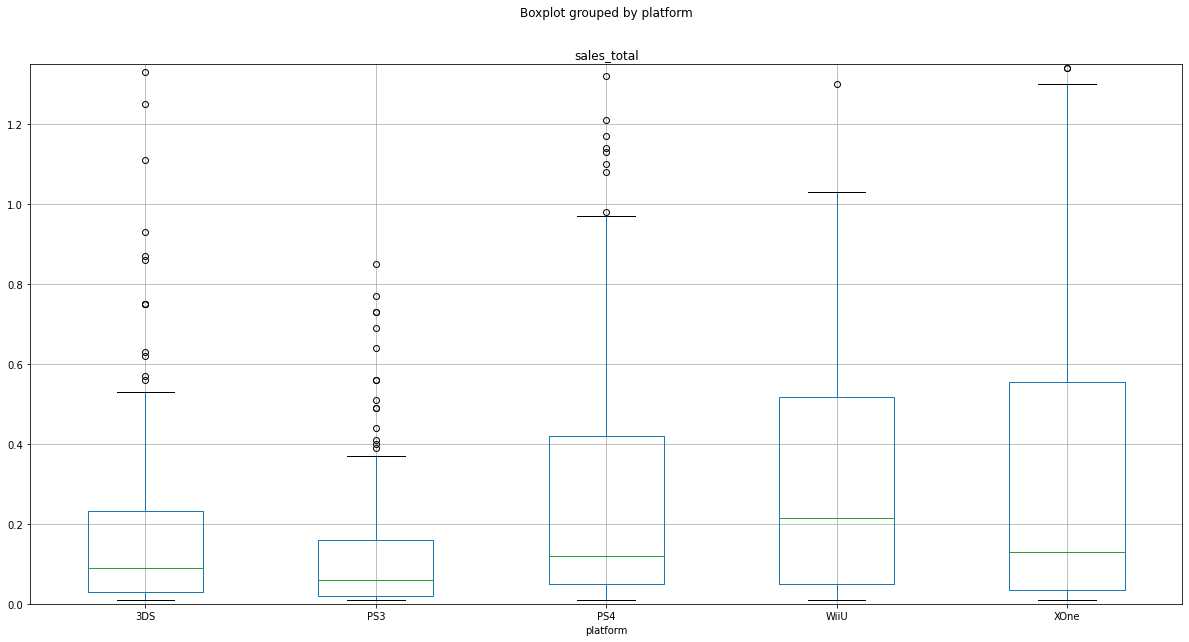

In [31]:
#В query записаны ключи по списку выше

data_1416.query('platform == ["PS4", "XOne", "3DS", "WiiU", "PS3"]').boxplot('sales_total', by='platform', figsize=(20, 10)).set_ylim(0, 1.35)

Видно, что лидеры продаж существенно превосходят другие платформы и ясно видна картина по конкурирующим платформам, которые владеют сегментом больших продаж - их отрыв от остальных консолей почти вдвое больше.

### Отзывы пользователей и критиков

Предпочтения критиков и пользователей с точки зрения платформ совпадает в большинстве случаев - Xbox One и PS4 оценивается выше, чем PS3 и, предположительно, Xbox 360. При этом пользователям PS Vita нравится больше, чем критикам, а вот критики наоборот оценивают чуть выше игры для ПК. 

[Text(0, 0.5, 'Рейтинг')]

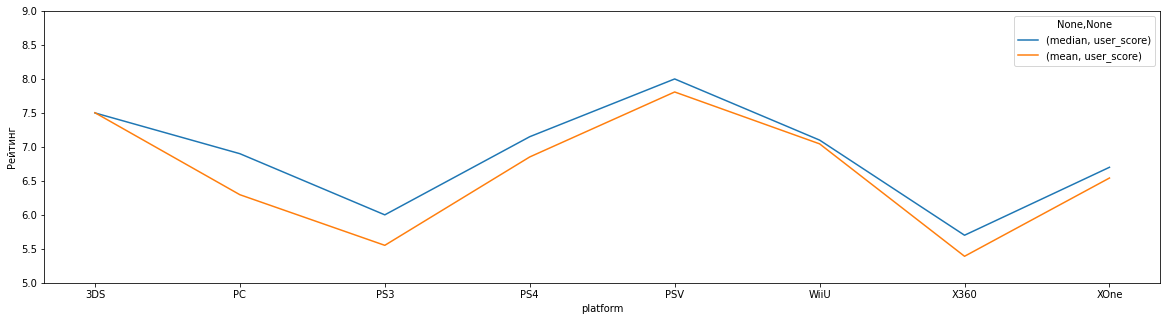

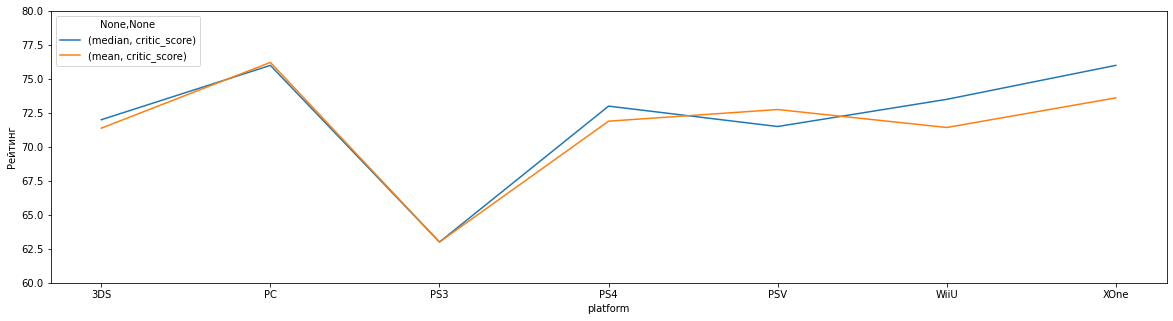

In [32]:
data_1416.pivot_table(index='platform', values=['user_score'], aggfunc=['median', 'mean']).plot(figsize=(20,5), style='-', ylim=[5,9]).set(ylabel='Рейтинг')
data_1416.pivot_table(index='platform', values=['critic_score'], aggfunc=['median', 'mean']).plot(figsize=(20,5), style='-', ylim=[60,80]).set(ylabel='Рейтинг')

#### Общая корреляция

Отзывы критиков на продажи влияют чуть сильнее, чем отзывы игроков.

Оценка критиков ниже 40 держит уровень примерно на 0,25 млн проданных копий, в то время как оценка ниже 4 от пользователей способна поднять продажи примерно до 0,5 млн проданных копий. 

При этом в целом общее мнение сходится: чем выше рейтинг, тем больше проданных копий.

[Text(0.5, 0, 'Отзывы игроков'), Text(0, 0.5, 'Количество проданных копий')]

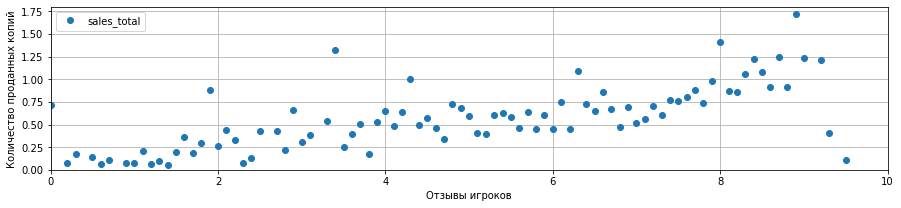

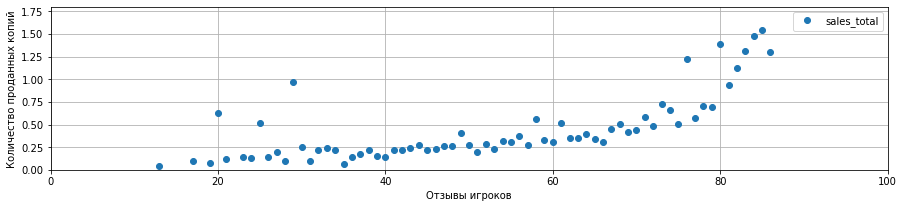

In [33]:
data_0616.pivot_table(index='user_score', values='sales_total').plot(figsize=(15,3), style='o', xlim=[0,10], ylim=[0,1.8], grid=True).set(xlabel='Отзывы игроков', ylabel='Количество проданных копий')
data_0616.pivot_table(index='critic_score', values='sales_total').plot(figsize=(15,3), style='o', xlim=[0,100], ylim=[0,1.8], grid=True).set(xlabel='Отзывы игроков', ylabel='Количество проданных копий')


Если посмотреть на корреляцию в матрице, то влияние пользователей на продажи действительно слабее, чем влияние критиков. Но и влияние критиков на сумму продаж находится на среднем уровне.

А вот связь между оценками пользователей и оценками критиков между собой коррелирует значительно, что означает схожесть мнений касательно игр.

In [34]:
data_0616[['user_score', 'critic_score', 'sales_total']].corr().style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).set_precision(2)

,user_score,critic_score,sales_total
user_score,1.00,0.57,0.08
critic_score,0.57,1.00,0.24
sales_total,0.08,0.24,1.00


#### Корреляция по платформам

##### В 2006 - 2016

Если смотреть на корреляцию по отдельным платформам, то картина получается следующей:
- Отзывы критиков в целом имеют видимое влияние на продажи игр для платформы Sony, за исключением портативных консолей: PS Vita, PS Portable
- Nintendo испытывает влияние отзывов меньше, чем Sony, однако на продажи примерно одинаково влияют и отзывы критиков, и отзывы игроков. Выделяется GameCube с сильной корреляцией, что ожидаемо - консоль сильно отличается от конкурентов тем, что использует диски на основе mini-DVD вместо полноразмерных DVD. Соответственно и отношение к консоли складывается отдельно, без привязки к конкурентам.
- Продажи Microsoft зависят в большей степени от критиков, а вот оценки пользователей порой не играют роли: так, оценки на Xbox One от пользователей не помешали продажам игр. 

In [35]:
#Корреляция оценок критиков и продаж за 2006-2016

for i in data_0616['platform'].unique():
    try:
        query = data_0616.query('platform == @i')
        critics_score_corr = query['critic_score'].corr(query['sales_total'])    
        print(i, 'оценка критиков:', critics_score_corr.round(2))

        user_score_corr = query['user_score'].corr(query['sales_total'])    
        print(i, 'оценка пользователей:', user_score_corr.round(2), '\n')
    except:
        pass

Wii оценка критиков: 0.18
Wii оценка пользователей: 0.11 

DS оценка критиков: 0.23
DS оценка пользователей: 0.12 

X360 оценка критиков: 0.4
X360 оценка пользователей: 0.12 

PS3 оценка критиков: 0.43
PS3 оценка пользователей: 0.13 

PS4 оценка критиков: 0.41
PS4 оценка пользователей: -0.03 

3DS оценка критиков: 0.35
3DS оценка пользователей: 0.22 

PC оценка критиков: 0.29
PC оценка пользователей: -0.02 

XOne оценка критиков: 0.42
XOne оценка пользователей: -0.07 

WiiU оценка критиков: 0.35
WiiU оценка пользователей: 0.4 

PS2 оценка критиков: 0.44
PS2 оценка пользователей: 0.18 

PSP оценка критиков: 0.32
PSP оценка пользователей: 0.24 

PSV оценка критиков: 0.13
PSV оценка пользователей: 0.01 

GBA оценка критиков: -0.18
GBA оценка пользователей: -0.75 

GC оценка критиков: 0.52
GC оценка пользователей: 0.39 

XB оценка критиков: 0.41
XB оценка пользователей: 0.28 



##### В 2014 - 2016

В последнее время влияние оценок пользователей на продажи игр по консолям стало гораздо меньше, в то время как влиние оценок критиков по-прежнему заметно. 

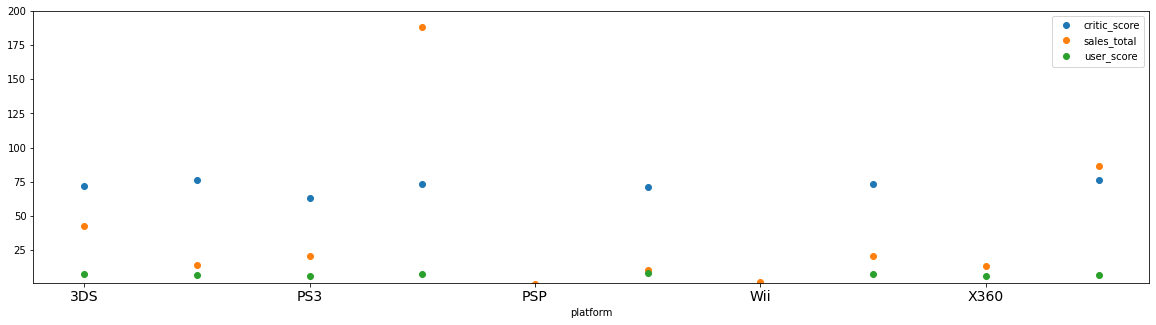

In [36]:
data_1416.pivot_table(index='platform', values=['user_score', 'critic_score', 'sales_total'], aggfunc={'sales_total': 'sum', 'user_score': 'median', 'critic_score': 'median'}).plot(figsize=(20,5), style='o', ylim=[1,200])
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

Что касается корреляции отзывов критиков и пользователей на суммы продаж в разрезе отдельных платформ, то имеет смысл смотреть их с точки зрения потенциально прибыльных, список которых был определён в пункте 4.2.1:
- Playstation4
- Nintendo 3DS
- Xbox One

Продажи игр на PS4 не сильно зависимы от оценок пользователей, в то время как оценка критиков выше 80 с большой долей вероятности принесёт доход от 0,5 млн проданных копий.

[Text(0.5, 0, 'Отзывы критиков на PS4'),
 Text(0, 0.5, 'Количество проданных копий')]

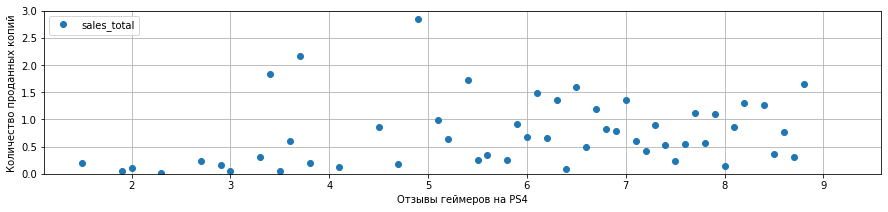

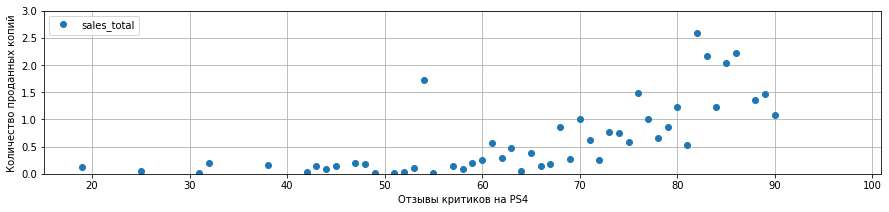

In [37]:
data_0616.query('platform == "PS4"').pivot_table(index='user_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы геймеров на PS4', ylabel='Количество проданных копий')
data_0616.query('platform == "PS4"').pivot_table(index='critic_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы критиков на PS4', ylabel='Количество проданных копий')

Nintendo 3DS же зависит от оценок гораздо меньше, чем Sony PS4, но и продажи у неё меньше.

[Text(0.5, 0, 'Отзывы критиков на 3DS'),
 Text(0, 0.5, 'Количество проданных копий')]

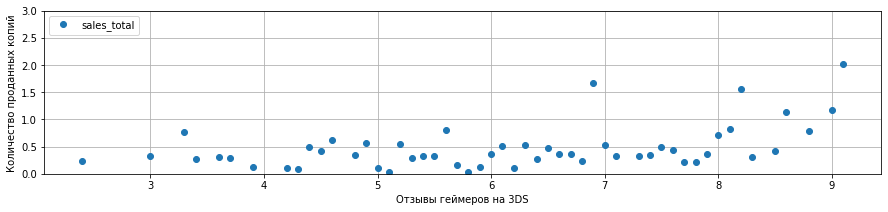

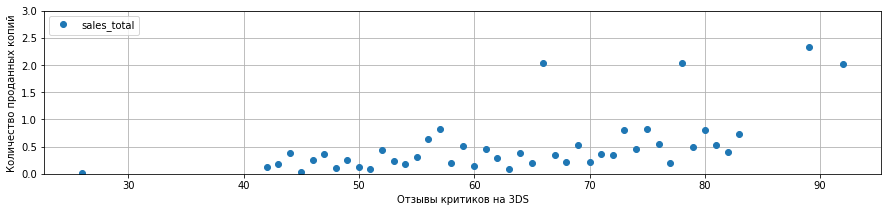

In [38]:
data_0616.query('platform == "3DS"').pivot_table(index='user_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы геймеров на 3DS', ylabel='Количество проданных копий')
data_0616.query('platform == "3DS"').pivot_table(index='critic_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы критиков на 3DS', ylabel='Количество проданных копий')

Microsoft же является прямым конкурентом Sony и настолько же крупным игроком рынка, поэтому консоль Xbox 360 подвержена влиянию оценок сильнее, чем Ninendo. Но и в этом случае нельзя говорить о прямой связи, хотя в общем есть вероятность получения прибыли от 0,5 млн проданных копий при оценках от критика от 70 баллов (что на 10 ниже, чем требуется для PS4).

[Text(0.5, 0, 'Отзывы критиков на X360'),
 Text(0, 0.5, 'Количество проданных копий')]

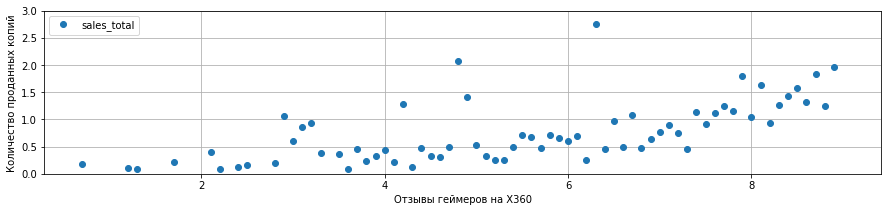

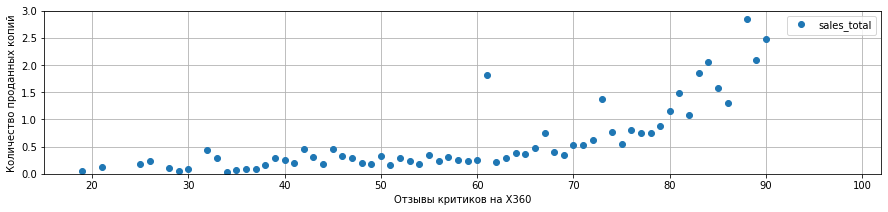

In [39]:
data_0616.query('platform == "X360"').pivot_table(index='user_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы геймеров на X360', ylabel='Количество проданных копий')
data_0616.query('platform == "X360"').pivot_table(index='critic_score', values='sales_total').plot(figsize=(15,3), style='o', ylim=[0,3], grid=True).set(xlabel='Отзывы критиков на X360', ylabel='Количество проданных копий')

### Игры по жанрам

Всего в датасете за актуальный период представлено 12 жанров игр:
- экшены самые прибыльные по общей сумме продаж и наиболее часто выпускаемые
- стратегии наименее прибыльные и по общим суммам продаж, и по медианному значению, но при этом выпускаются чаще платформеров
- платформеры наименее выпускаемые, но на 7 месте по прибыльности среди всех жанров
- шутеры наиболее прибыльные со стороны медианного значения, но по суммам продаж находятся на третьей позиции

In [40]:
data_0616.pivot_table(index=['genre'], values=['sales_total', 'name'], 
                 aggfunc={'sales_total': [sum, 'median'], 'name': 'count'}).sort_values(('sales_total', 'sum'), ascending=False)

name sales_total         
             count      median      sum
genre                                  
Action        2383       0.160  1116.67
Sports        1262       0.200   793.85
Shooter        737       0.290   717.04
Misc          1253       0.130   554.86
Role-Playing   996       0.150   522.40
Racing         562       0.170   299.00
Platform       340       0.225   279.74
Simulation     606       0.130   220.65
Fighting       413       0.160   188.42
Adventure     1023       0.040   141.35
Puzzle         366       0.080    89.92
Strategy       393       0.070    73.14

Популярность экшенов легко объяснима: они активны, интересны одинаково в командной и одиночной игре, заставляют геймеров включаться со стороны рефлексов и скорости реакций, что открывает в мультиплеере широкое поле для соревнований в ловкости, хитрости, тактике и стратегии.

Стратегии же выпускаются в меньшем объёме и постепенно теряют аудиторию, что приводит к падению интереса крупных игроков рынка. Инди-разработчики выпускают игры по-прежнему, однако не могут обеспечить высокий уровень популярности, а как было сказано в пункте 3.1.4, где рассматривался спад рынка в 2012 году - игра должна быть коммерчески выгодна.

Если же рассматривать вопрос со стороны почему экшены в принципе популярнее стратегий, то здесь важным фактором является графика.

Немалый вклад в развитие графики в играх был внесён движком Unreal Engine: анимация, текстуры, пост-обработка, направленная в том числе на тени и отражения. В стратегиях графика не так сильно выражена, как правило, игры представлены в изометрии или через вид сверху, в то время как экшены уже позволяют геймеру играть от первого лица и вовлекаться в игровой мир. Объекты становятся не статичными, а объёмными, также как и взаимодействие с ними. Unreal Engine 2, вышедший в 2002, стал предлагать в играх имитацию жидкостей, генерацию декоративных элементов ландшафта и получил встроенный движок Karma. Karma позволила добиться реалистичной физики, однако уже приносила затруднения при использовании 32-битной графики. Следующие версии расширяли возможности графики и если посмотреть на Unreal Engine 4 - возможности движка в экшен-играх уже были зрелищными, например, как в этом [демо](https://www.youtube.com/watch?v=kr2oHPSJ0m8).

Кроме Unreal Engine были и другие движки, что в итоге играло в пользу выбора зрелищных и эффектных игр даже среди геймеров, предпочитающий менее активные игры. То есть сравнивая, например, стратегию Command & Conquer с экшенами GTA 5 и Crysis, графика явно на стороне экшенов.

## Портрет пользователя по регионам

### Ввод новых переменных для удобства сравнения

#### Компании-производители

Для удобства добавим в таблицу названия компаний, к которым принадлежат консоли.

In [41]:
#Уточнение списка актуальных консолей для фунции
data_0616['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'WiiU',
       'PS2', 'PSP', 'PSV', 'GBA', 'GC', 'XB', 'DC'], dtype=object)

In [42]:
#Функция для добавления компании, для консолей вне списка актуальных компания указываться не будет
#Несмотря на то, что PC, скорее всего, про игры под Windows, это всё-таки не консоль, поэтому считается отдельно от Microsoft

def platform_company(row):
    try:
        if 'DS' in row or 'Wii' in row or 'G' in row:
            return 'Nintendo'
        elif 'X' in row:
            return 'Microsoft'
        elif 'PS' in row:
            return 'Sony'        
        elif 'DC' in row:
            return 'Sega'                
        elif 'PC' in row:
            return 'PC'
    except:
        pass

In [43]:
#Запись нового столбца, перезапись переменной со срезом на актуальный период

data['platform_company'] = data['platform'].apply(platform_company)
data_0616 = data.query('year_of_release > 2005')
data_1416 = data.query('year_of_release > 2014')

#### Срезы по регионам

Для удобства сохраним в отдельные переменные срезы по странам. Так как портрет пользователя нужен не для понимания тенденций развития игровой индустрии, а для построения картины под прогноз на основе потенциально прибыльных продуктов, то срезы будут сделаны не по актуальному периоду, а по периоду для бизнес-исследования, т.е. 2014-2016

In [44]:
#Сортировка по количеству продаж, если там 0, то игра не была представлена на рынке
#Принцип наименования: jp - Japan, eu - Europe, na - North America, s1 - some1 - someone

jp = data_1416.query('jp_sales > 0')
eu = data_1416.query('eu_sales > 0')
na = data_1416.query('na_sales > 0')
s1 = data_1416.query('other_sales > 0')

#### Суммарные продажи по регионам

Для удобства сравнения в отдельные переменные будут записаны сводные таблицы по продажам для каждого региона, в которых будут включены:
- Название платформы
- Компания-производитель
- Количество выпущенных наименований игр
- Сумма продаж в регионе
- Доля продаж на платформу среди общего количества продаж региона

In [45]:
#Создание таблиц
#Принцип наименования: регион, st - sales total

#Япония
jp_st = jp.pivot_table(index=['platform'], values=['name', 'jp_sales'], aggfunc={'name':np.count_nonzero, 'jp_sales':np.sum}).sort_values(by='jp_sales', ascending=False)
jp_st['platform_company'] = jp.groupby('platform')['platform_company'].unique()
jp_st['sales_pie'] = (jp.groupby('platform')['jp_sales'].sum()/jp['jp_sales'].sum()*100).round(2)
jp_st = jp_st.reset_index()
jp_st = jp_st[['platform', 'platform_company', 'name', 'jp_sales', 'sales_pie']]

#Европа
eu_st = eu.pivot_table(index=['platform'], values=['name', 'eu_sales'], aggfunc={'name':np.count_nonzero, 'eu_sales':np.sum}).sort_values(by='eu_sales', ascending=False)
eu_st['platform_company'] = eu.groupby('platform')['platform_company'].unique()
eu_st['sales_pie'] = (eu.groupby('platform')['eu_sales'].sum()/eu['eu_sales'].sum()*100).round(2)
eu_st = eu_st.reset_index()
eu_st = eu_st[['platform', 'platform_company', 'name', 'eu_sales', 'sales_pie']]

#Северная Америка
na_st = na.pivot_table(index=['platform'], values=['name', 'na_sales'], aggfunc={'name':np.count_nonzero, 'na_sales':np.sum}).sort_values(by='na_sales', ascending=False)
na_st['platform_company'] = na.groupby('platform')['platform_company'].unique()
na_st['sales_pie'] = (na.groupby('platform')['na_sales'].sum()/na['na_sales'].sum()*100).round(2)
na_st = na_st.reset_index()
na_st = na_st[['platform', 'platform_company', 'name', 'na_sales', 'sales_pie']]

#Остальные страны
s1_st = s1.pivot_table(index=['platform'], values=['name', 'other_sales'], aggfunc={'name':np.count_nonzero, 'other_sales':np.sum}).sort_values(by='other_sales', ascending=False)
s1_st['platform_company'] = s1.groupby('platform')['platform_company'].unique()
s1_st['sales_pie'] = (s1.groupby('platform')['other_sales'].sum()/s1['other_sales'].sum()*100).round(2)
s1_st = s1_st.reset_index()
s1_st = s1_st[['platform', 'platform_company', 'name', 'other_sales', 'sales_pie']]

### Популярность платформ

#### По количеству релизов

Что касается портрета пользователей со стороны платформ и выпускаемых под них игр, то картина следующая:
- в Японии лидируют платформы Sony, что неудивительно, т.к. Sony - японская компания и выходит она раньше именно на японский рынок
- в Европе также больше игр выходит для Sony, на втором месте Microsoft, однако отличительная особенность аудитории - большое количество ПК-геймеров
- Для Северной Америки больше всего игр выходило также на консоли Sony
- Аудитория остальных стран представляет собой что-то среднее между европейским и северо-американским сегментам аудитории

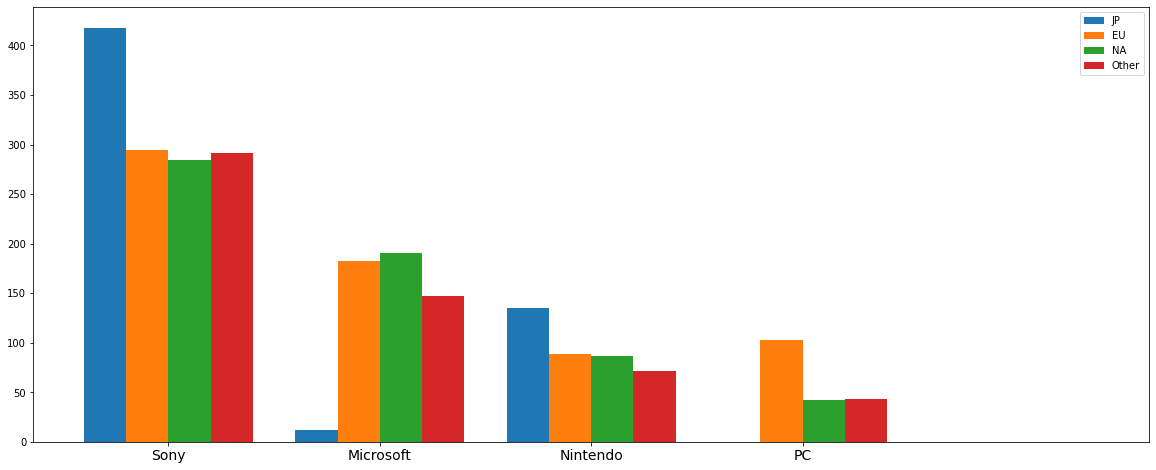

In [46]:
plt.figure(figsize=(20,8))
plt.hist([jp['platform_company'], eu['platform_company'], na['platform_company'], s1['platform_company']], label=['JP', 'EU', 'NA', 'Other'], rwidth=0.8, align='left', bins=range(6))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

Если смотреть на платформы в частности, то наибольшую популярность в Японии приобрели игры для портативных моделей - PlayStation Vita, при этом PSP также получает здесь игр больше, чем в остальных регионах. На втором месте по популярности после PS Vita находится PS4.

В Европе наибольшее количество игр выходит для PS4 и Xbox One, чуть меньше для ПК и практически ничего не выпускается для Wii.

В Северной Америке в топе PS4, Xbox One, на третьем месте по количеству игр - Nintendo 3DS.

Остальные же страны снова повторяют общую картину европейского потребителя с единственным заметным отличием - на третьем месте по количеству игр PS3, а не ПК.

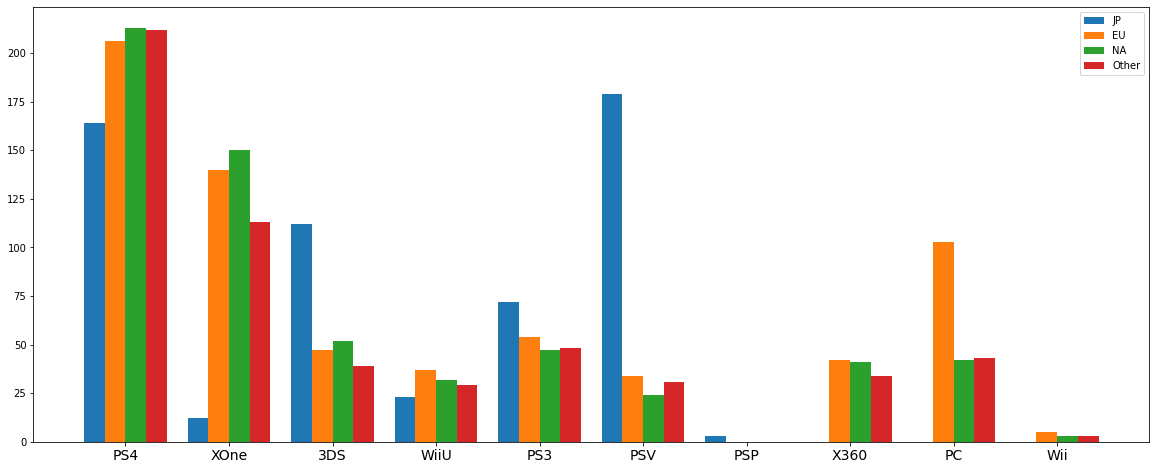

In [47]:
plt.figure(figsize=(20,8))
plt.hist([jp['platform'], eu['platform'], na['platform'], s1['platform']], label=['JP', 'EU', 'NA', 'Other'], rwidth=0.8, align='left', bins=range(11))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

#### По общим продажам

Топ по продажам на платформах складывается следующим образом:
- Япония
 - лидирует Nintendo 3DS, уверенно обгоняя Sony, чья PS4 занимает второе место, а PSVita - третье
 - в пятёрке лидеров нет платформ от не японских компаний
- Европа
 - Sony с консолью PS4 незначительно обгоняет Microsoft с консолью XBox One, замыкает тройку ПК
 - замыкает рейтинг примерно с равным количеством продаж Nintendo 3DS и Sony PlayStation 3
- Северная Америка
 - PS4 и Xbox One занимают уверенные первые два места
 - Nintendo 3DS, Wii U и Microsoft Xbox360 идут с заметным отрывом от лидеров и замыкают рейтинг
- Остальные страны
 - Уверенно лидирует PS4
 - Xbox One показывает значительно меньший уровень продаж
 - Ещё слабее продажи идут у PS3, 3DS и WiiU

In [48]:
print('Япония', '\n', jp.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Европа', '\n', eu.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Северная Америка', '\n', na.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Другие страны', '\n', s1.groupby('platform')['other_sales'].sum().sort_values(ascending=False).head(5), '\n')

Япония 
 platform
3DS     23.55
PS4     12.05
PSV      8.41
PS3      4.97
WiiU     4.12
Name: jp_sales, dtype: float64 

Европа 
 platform
PS4     83.54
XOne    28.10
PC       9.10
3DS      7.39
PS3      7.30
Name: eu_sales, dtype: float64 

Северная Америка 
 platform
PS4     63.86
XOne    50.30
3DS     10.31
WiiU     8.86
X360     8.05
Name: na_sales, dtype: float64 

Другие страны 
 platform
PS4     28.70
XOne     7.71
PS3      2.49
3DS      1.67
WiiU     1.48
Name: other_sales, dtype: float64 



#### По доли продаж

##### Доля продаж в Японии

Наибольшую часть по продажам получает Nintendo, захватившая почти 52% японского рынка. Sony отстаёт примерно на 4%, а вот Microsoft представлена очень слабо.

(array([], dtype=float64), [])

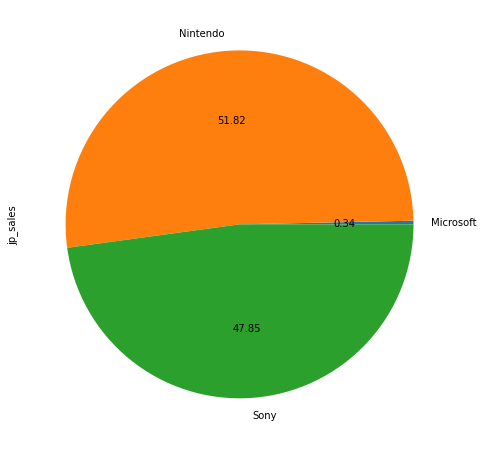

In [49]:
plt.figure(figsize=(20,8))
jp.groupby('platform_company')['jp_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

Что касается картины по отдельным платформам, около 44% проданных копий в Японии были предназначены для Nintendo 3DS. А вот на долю Xbox One пришлось менее 1% от общего числа продаж.

In [50]:
jp_st

,platform,platform_company,name,jp_sales,sales_pie
0,3DS,[Nintendo],112,23.55,44.10
1,PS4,[Sony],164,12.05,22.57
2,PSV,[Sony],179,8.41,15.75
3,PS3,[Sony],72,4.97,9.31
4,WiiU,[Nintendo],23,4.12,7.72
5,XOne,[Microsoft],12,0.18,0.34
6,PSP,[Sony],3,0.12,0.22


##### Доля продаж в Европе

На европейском рынке Sony по суммарным продажам захватила примерно 62% рынка, Microsoft примерно 22%, а Nintendo - чуть меньше 10%.

На последнем же месте ПК-геймеры, на долю которых пришлось примерно 6% всех проданных в Европе игр.

(array([], dtype=float64), [])

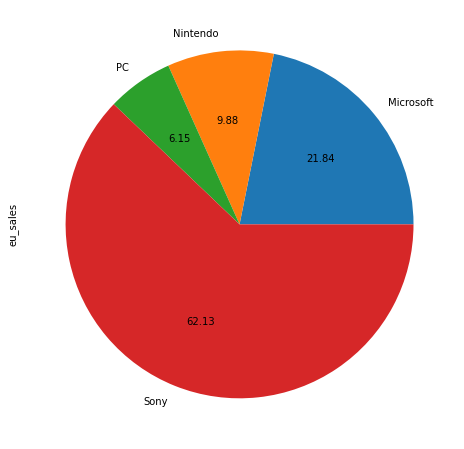

In [51]:
plt.figure(figsize=(20,8))
eu.groupby('platform_company')['eu_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

Что касается картины по отдельным платформам, то лидирует PS4 и фактически это основной доход Sony с европейского рынка. Xbox One получает 19%, Nintendo 3DS - не более 5%.

На последнем месте и по продажам, и по количеству выпущенных игр находится Wii, поддержка которой официально прекращена в 2013, но для которой выпускались игры вплоть до 2016.

In [52]:
eu_st

,platform,platform_company,name,eu_sales,sales_pie
0,PS4,[Sony],206,83.54,56.47
1,XOne,[Microsoft],140,28.10,18.99
2,PC,[PC],103,9.10,6.15
3,3DS,[Nintendo],47,7.39,5.00
4,PS3,[Sony],54,7.30,4.93
5,WiiU,[Nintendo],37,6.49,4.39
6,X360,[Microsoft],42,4.21,2.85
7,PSV,[Sony],34,1.08,0.73
8,Wii,[Nintendo],5,0.73,0.49


In [53]:
#Игры, выпущенные для Wii

eu.query('platform == "Wii"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total,platform_company
2151,Just Dance 2016,Wii,2015,Misc,0.41,0.46,0.0,0.08,NaN,NaN,E10+,0.95,Nintendo
7885,Just Dance 2017,Wii,2016,Misc,0.06,0.11,0.0,0.01,NaN,NaN,E10+,0.18,Nintendo
8800,Skylanders: SuperChargers,Wii,2015,Action,0.02,0.12,0.0,0.01,NaN,NaN,<NA>,0.15,Nintendo
14451,Barbie and Her Sisters Puppy Rescue,Wii,2015,Action,0.00,0.03,0.0,0.00,NaN,NaN,E,0.03,Nintendo
16048,Monster High: New Ghoul in School,Wii,2015,Action,0.00,0.01,0.0,0.00,NaN,NaN,E,0.01,Nintendo


##### Доля продаж в Северной Америке

В Северной Америке продажи у Nintendo примерно на 3% лучше, чем на европейском, но всё ещё почти на 39% ниже, чем на японском рынке.

Sony же продолжает лидировать, но разрыв между Sony и Microsoft уже меньше. А вот ПК-гейминг теряет в продажах примерно на 4% по сравнению с Европой.

(array([], dtype=float64), [])

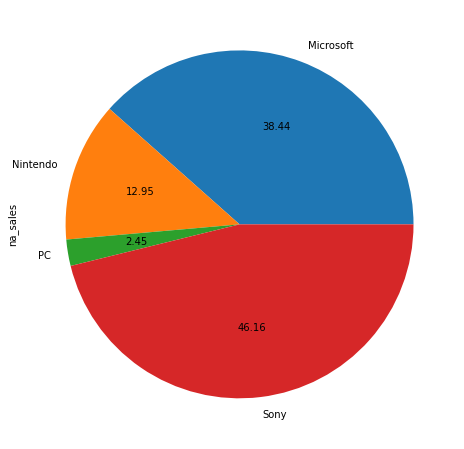

In [54]:
plt.figure(figsize=(20,8))
na.groupby('platform_company')['na_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

Что касается картины по отдельным платформам, то снова лидирует PS4, а Xbox One на втором месте. 

Nintendo получает прибыль с продаж игр для 3DS в размере примерно 7% от общего рынка.

In [55]:
na_st

,platform,platform_company,name,na_sales,sales_pie
0,PS4,[Sony],213,63.86,42.07
1,XOne,[Microsoft],150,50.30,33.14
2,3DS,[Nintendo],52,10.31,6.79
3,WiiU,[Nintendo],32,8.86,5.84
4,X360,[Microsoft],41,8.05,5.30
5,PS3,[Sony],47,5.66,3.73
6,PC,[PC],42,3.72,2.45
7,PSV,[Sony],24,0.54,0.36
8,Wii,[Nintendo],3,0.49,0.32


##### Доля продаж в остальных странах

Ранее было установлено, что в целом картина по остальным странам является чем-то средним между европейским и северо-американским типом.

Действительно, также как и в Европе и Северной Америке, на рынке остальных стран лидирует Sony. Однако, именно здесь компания получила наибольшую сумму продаж - почти 71%.

На долю Microsoft приходится примерно 20% рынка, Nintendo - 7,3%, а ПК-гейминг приносит около 2% продаж, что чуть меньше, чем в Северной Америке, но всё ещё больше, чем в Японии. 

(array([], dtype=float64), [])

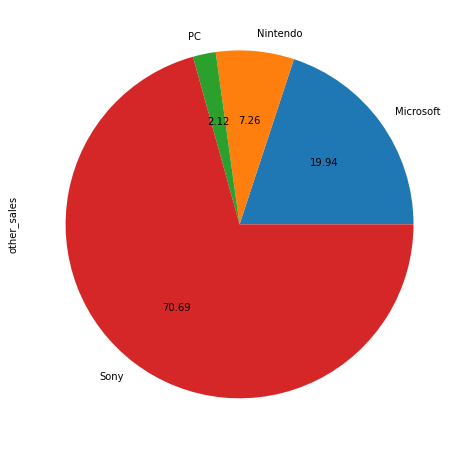

In [56]:
plt.figure(figsize=(20,8))
s1.groupby('platform_company')['other_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

Что касается картины по отдельным платформам, то примерно 64% всех продаж приходится на долю PS4.

Затем около 17% получает Xbox One, а на третьем месте снова Sony, но уже с консолью PS3.

In [57]:
s1_st

,platform,platform_company,name,other_sales,sales_pie
0,PS4,[Sony],212,28.70,64.08
1,XOne,[Microsoft],113,7.71,17.21
2,PS3,[Sony],48,2.49,5.56
3,3DS,[Nintendo],39,1.67,3.73
4,WiiU,[Nintendo],29,1.48,3.30
5,X360,[Microsoft],34,1.22,2.72
6,PC,[PC],43,0.95,2.12
7,PSV,[Sony],31,0.47,1.05
8,Wii,[Nintendo],3,0.10,0.22


### Популярность жанров

#### По количеству релизов

Геймеры в большинстве своём любят экшены, при этом наиболее жанр востребован в Японии, а наименее - в остальных странах.

Платформеры, паззлы, симуляторы и стратегии же не настолько популярны.

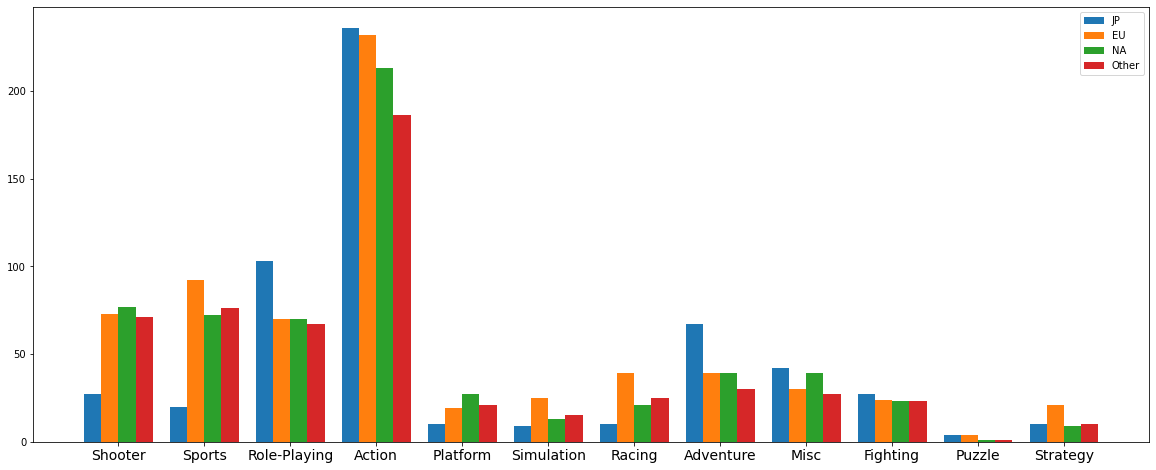

In [58]:
plt.figure(figsize=(20,8))
plt.hist([jp['genre'], eu['genre'], na['genre'], s1['genre']], label=['JP', 'EU', 'NA', 'Other'], rwidth=0.8, align='left', bins=range(13))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

На рынке Японии первую тройку по количеству выпущенных игр уверенно держат экшены, ролевые игры и приключения. На последнем - паззлы. 

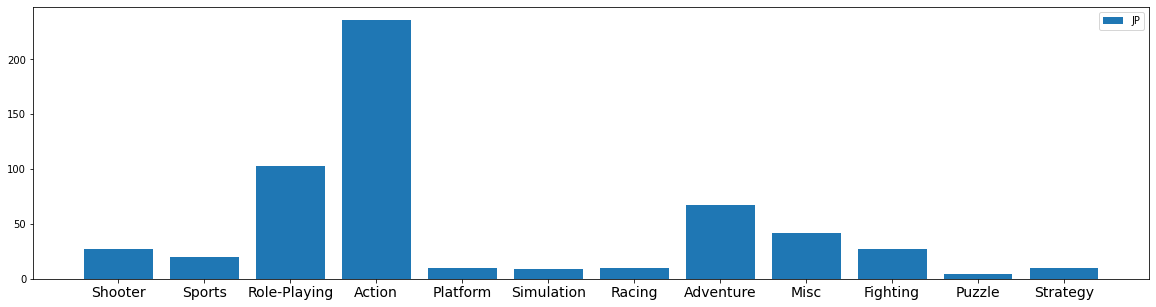

In [59]:
plt.figure(figsize=(20,5))
plt.hist([jp['genre']], label=['JP'], rwidth=0.8, align='left', bins=range(13))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

Причины популярности экшена были разобраны в пункте 4.3 "Игры по жанрам", но если вкратце - графика и эффекты. Что касается ролевыех игр и приключений, то здесь нужно вернуться к распределению по платформам. На японском рынке лидирует Nintendo, а значит и может диктовать свои правила. Pokemon, Dragon Quest и прочие - это игры именно для консолей Nintendo.

Если посмотреть топ самых продаваемых игр, то ролевая игра Pokemon - на третьем месте, сразу после экшенов.

In [60]:
jp.sort_values(by='jp_sales', ascending=False).head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total,platform_company
404,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,<NA>,3.32,Nintendo
685,Yokai Watch Busters,3DS,2015,Action,0.00,0.00,2.29,0.00,NaN,NaN,<NA>,2.29,Nintendo
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,<NA>,7.14,Nintendo


В Европе после экшенов наиболее часто выпускают спортивные игры и шутеры, а заметны они в немалой степени благодаря сериям FIFA и Call of Duty.

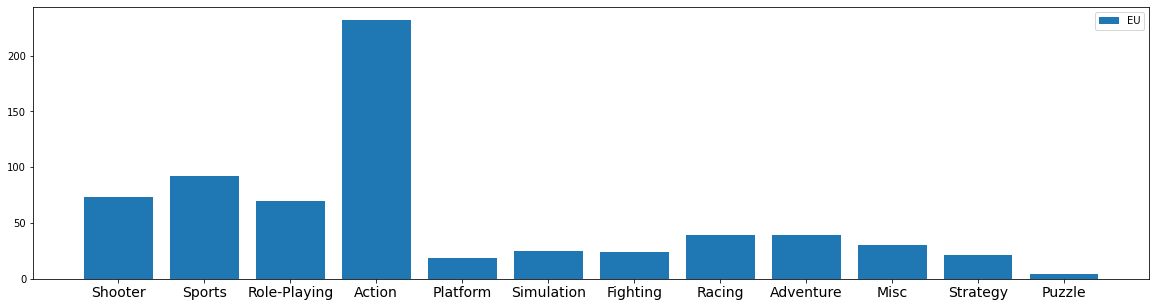

In [61]:
plt.figure(figsize=(20,5))
plt.hist([eu['genre']], label=['EU'], rwidth=0.8, align='left', bins=range(13))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

В Северной Америке на первом месте по количеству выпущенных игр экшены и шутеры, а спортивные примерно на одном уровне с ролевыми.

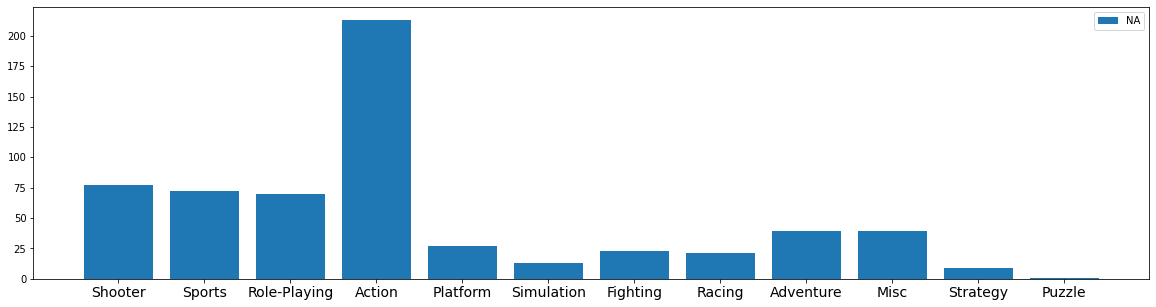

In [62]:
plt.figure(figsize=(20,5))
plt.hist([na['genre']], label=['NA'], rwidth=0.8, align='left', bins=range(13))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

Остальные же страны по количеству выпущенных игр не сильно отличаются от картины по Европе: экшены, шутеры и спортивные игры.

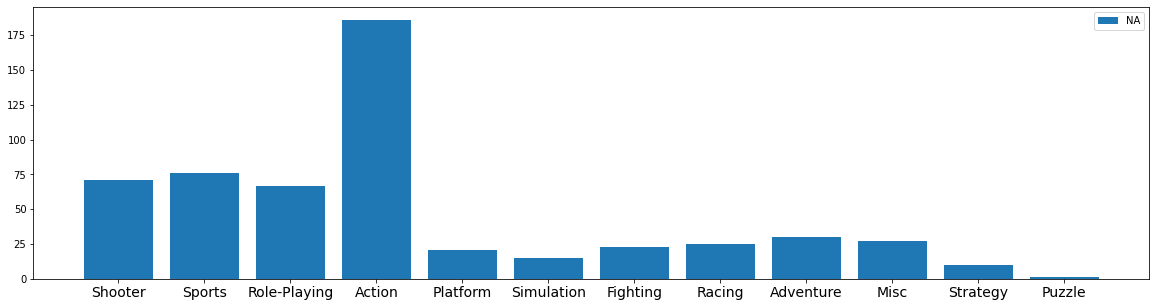

In [63]:
plt.figure(figsize=(20,5))
plt.hist([s1['genre']], label=['NA'], rwidth=0.8, align='left', bins=range(13))
plt.xticks(size=14)
plt.legend(loc='upper right')
plt.show()

#### По общим продажам

Топ по продажам на платформах складывается следующим образом.

- Япония
 - Экшены являются самыми продаваемыми, за ними располагаются ролевые игры.
 - Со значительным отрывом замыкают рейтинг шутеры, категория "Разное" и приключения

- Европа
 - Топ по продажам совпадает и с топом по количеству выпущенных игр: шутеры, экшены, спортивные игры
 - Замыкают топ ролевые игры и гонки
 
- Северная Америка
 - На первом месте по продажам шутеры, на втором экшены, а на третьем - спортивные
 - Четвёртое место - ролевые, пятое - Misc
 
- Остальные страны
 - Топ по продажам полностью совпадает с топом по продажам в Северной Америке и Европе.
 - На четвёртом ролевые игры, а на пятом - файтинги

In [64]:
print('Япония', '\n', jp.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Европа', '\n', eu.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Северная Америка', '\n', na.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5), '\n')
print('Другие страны', '\n', s1.groupby('genre')['other_sales'].sum().sort_values(ascending=False).head(5), '\n')

Япония 
 genre
Action          23.05
Role-Playing    13.41
Shooter          3.79
Misc             3.19
Adventure        2.22
Name: jp_sales, dtype: float64 

Европа 
 genre
Shooter         40.28
Action          34.82
Sports          27.82
Role-Playing    17.21
Racing           6.52
Name: eu_sales, dtype: float64 

Северная Америка 
 genre
Shooter         48.18
Action          33.68
Sports          26.31
Role-Playing    19.82
Misc             5.58
Name: na_sales, dtype: float64 

Другие страны 
 genre
Shooter         13.48
Action          10.58
Sports           8.55
Role-Playing     5.38
Fighting         1.57
Name: other_sales, dtype: float64 



### Влияние рейтинга ESRB на продажи в регионе

#### Япония

В Японии наибольшую прибыль приносят игры категория для подростков, на втором месте игры для всех возрастов, на третьем для взрослых и замыкает топ по продажам категория от 10 и старше.

В целом, можно говорить о том, что игры с высоким рейтингом в Японии будут менее востребованны, что может быть связано с высокой игровой вовлечённостью школьников в игры - игровые автоматы тайко, dance dance revolution и прочие привлекают молодую аудиторию, которая потом может захотеть поиграть в такие же игры и дома. Например, игровые автоматы тайко давно перенесены в игру под названием Taiko no tatsujin, запускаемую как на стационарных консолях, так и в портативных версиях от Sony и Nintendo.

(array([], dtype=float64), [])

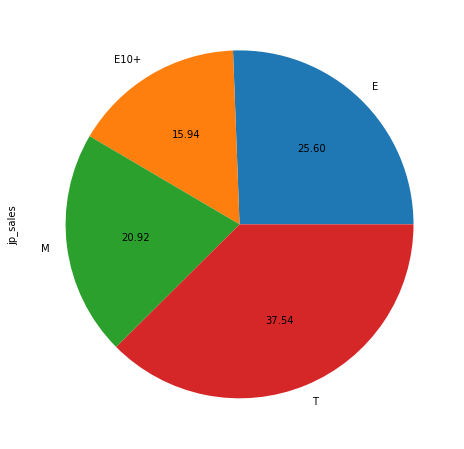

In [65]:
plt.figure(figsize=(20,8))
jp.groupby('rating')['jp_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

#### Европа

В Европе картина меняется, лидером по продажам является категория 17+, за ней игры для подростков и замыкает рейтинг игры для всех возрастов. Возвращаясь к популярным жанрам региона, экшены и шутеры действительно в большей степени относятся к играм для людей старше 17 лет.

Поэтому рейтинг М может значительно поднять продажи при релизе на европейском рынке.

(array([], dtype=float64), [])

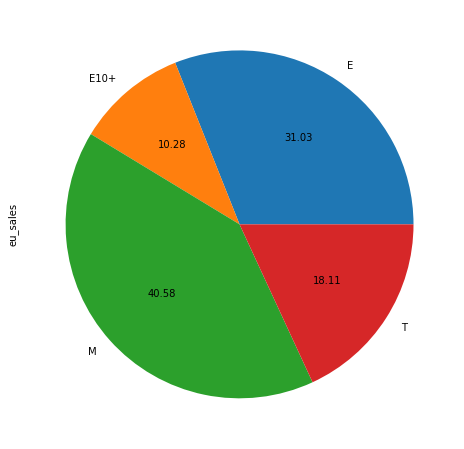

In [66]:
plt.figure(figsize=(20,8))
eu.groupby('rating')['eu_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

#### Северная Америка

В Северной Америке также популярны категории E и M, а категория для тинейджеров находится на третьем месте и в Северной Америке она принесла примерно на 2% больше прибыли, чем в Европе.

(array([], dtype=float64), [])

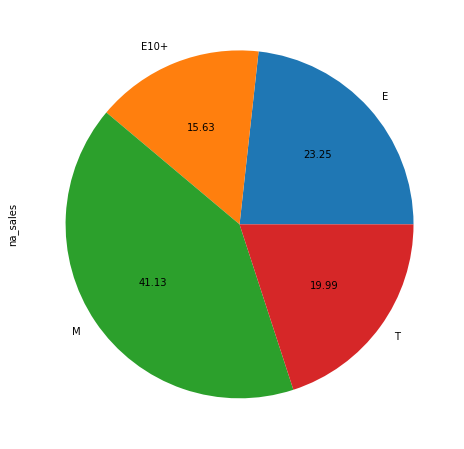

In [67]:
plt.figure(figsize=(20,8))
na.groupby('rating')['na_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

#### Остальные страны

В остальных странах топ повторяется: категории 17+, 13+ и для всех возрастов, поэтому здесь также, как и в Европе и в Северной Америке рейтинг М в игре может повысить уровень продаж.

(array([], dtype=float64), [])

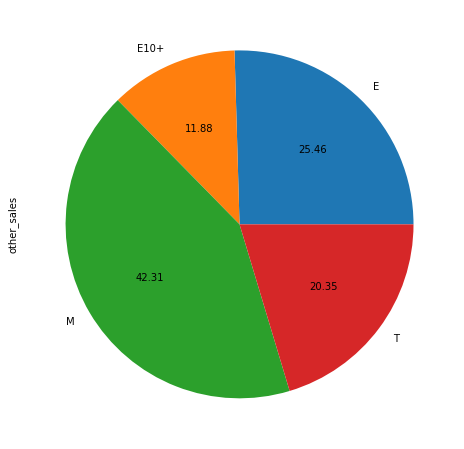

In [68]:
plt.figure(figsize=(20,8))
s1.groupby('rating')['other_sales'].sum().plot(kind='pie', autopct='%.2f')
plt.xticks(size=14)

## Проверка гипотез

Методом проверки гипотез выбран метод **st.ttest_ind**, предназначенный для проверки равенства между двумя совокупностями, что как раз подходит для поставленной задачи.

Сравнение происходит через получаемое p-значение, которое показывает равны ли средние или нет - если получаемое p-значение мало, значит средние не равны, соответственно и гипотезу следует принять альтернативную.

### Рейтинги платформ Xbox One и PC одинаковые

Первая гипотеза для проверки:<br>
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [71]:
#Проверка гипотезы, критический уровень статистической значимости - 0.05

alpha= .05

results = st.ttest_ind(
    data_1416.query('platform == "PC" and user_score > 0')['user_score'], 
    data_1416.query('platform == "XOne" and user_score > 0')['user_score'])

print('p-значение:', results.pvalue.round(2))

if results.pvalue < alpha:
    print("Да, рейтинги платформ Xbox One и PC одинаковые")
else:
    print("Нет, рейтинги платформ Xbox One и PC не равны") 

p-значение: 0.28
Нет, рейтинги платформ Xbox One и PC не равны


Гипотеза не подтверждена, а значит средние пользовательские рейтинги платформ Xbox One и PC **не равны**.

### Рейтинги жанров Action и Sports разные

Вторая гипотеза для проверки:<br>
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [72]:
#Проверка гипотезы, критический уровень статистической значимости - 0.05

alpha= .05

results = st.ttest_ind(
    data_0616.query('genre == "Action" and user_score > 0')['user_score'], 
    data_0616.query('genre == "Sports" and user_score > 0')['user_score'])

print('p-значение:', results.pvalue.round(2))

if results.pvalue < alpha:
    print("Да, средние пользовательские рейтинги жанров Action и Sports не совпадают")
else:
    print("Нет, средние пользовательские рейтинги жанров Action и Sports равны") 

p-значение: 0.0
Да, средние пользовательские рейтинги жанров Action и Sports не совпадают


Гипотеза не подтверждена, а значит средние пользовательские рейтинги жанров Action и Sports **не равны**.

## Итоги исследования

Игровая индустрия сейчас находится в состоянии падения и выход новых поколений платформ не имеет такой сильной популярности, какую имели первые поколения. Введение донатных систем, развитие мобильных игр, рост требовательности игр в связи с повышением графики и эффектов - это приводит к тому, что консоли начинают постепенно сдавать позиции. Однако, у крупных производителей есть и ресурсы, и лояльность аудитории, и обширный опыт продвижения, что позволяет им удерживать высокую планку доходов на протяжении долгого времени.

В целом картина по рынку имеет отличительные особенности только для работы в Японии, но так как исследование проводилось не для японского потребителя, то и нюансы Японии учитывать не требуется.

Ориентируясь на цель исследования - выявить потенциально популярные продукты для планирования рекламных компаний, можно говорить о следующем:
- По платформам
  - Игры для поколений консолей Xbox One, PS4, 3DS - интересны, но перед определением объёма закупок следует ещё раз посмотреть новости и отзывы игроков. Если продажи PS4 не вызывают вопросов, то у XBox One продажи игр на данный момент не показывают значительного роста
  - Игры под PS3 и Xbox 360 всё ещё найдут своего потребителя и потенциально могут продолжать показывать хорошую прибыль на следующий год

- По жанрам
 - Экшены, шутеры - это то, что будет интересно игрокам широкого сегмента
 - Спортивные игры, ролевые игры - также имеют свою аудиторию и потенциально обещают хорошую прибыль
 - Паззлы, платформеры, стратегии - то, на что точно не стоит делать ставку
- По рейтингу ESRB
 - Потенциально прибыльными являются игры для всех возрастов и категории 17+
 - На втором месте стоит обратить внимание на игры для тинейджеров
 - Игры возраста от 3+ с высокой долей вероятности не принесут прибыли
 
 Резюмируя, можно сказать о том, что наибольшую прибыль, скорее всего, принесут экшены и шутеры для PS3/4, Xbox360/XBox One. Также могут быть интересными игры на Nintendo 3DS с категорией для всех возрастов, так что стоит присмотреться к выпуску новых релизов.

<div style="border:solid Chocolate 2px; padding: 40px">
    
**Общий вывод по проекту ревьювера**:
 Юлия, спасибо за  проект! Ты приложила много усилий, чтобы довести его до конца, проделана огромная работа, и это видно невооруженным глазом, ты большой молодец!
    
**Отмечу положительные моменты**:
    
    1. Все разложено по полочкам, всегда понятен ход твоих мыслей, приятно смотреть
    
    2. Отличные визуализации
    
    3. На разных шагах проекта ты предлагала очень интересные решения и методы для их реализации. Хорошая работа!